# Polynomial regression with deep networks analysis

In [1]:
# note that the command to train is python -m src.train_nn with mlp_regression_config dataset_name=poly

import sys
sys.path.append('..')

import numpy as np
import itertools
import matplotlib.pylab as plt
import pandas as pd
from tqdm import tqdm
from IPython import display
import warnings
from src.visualization import draw_mlp_clustering_report, run_double_spectral_cluster
from src.utils import get_weights_paths, build_clustering_results, suppress, all_logging_disabled
from src.experiment_tagging import get_model_path, MODEL_TAG_LOOKUP
from src.spectral_cluster_model import SHUFFLE_METHODS
from src.lesion import (perform_lesion_experiment, do_lesion_hypo_tests,
                        plot_all_damaged_clusters, compute_damaged_cluster_stats,
                        plot_overall_damaged_clusters)
from src.pointers import DATA_PATHS

Using TensorFlow backend.


In [2]:
model_tags = ('POLY', 'POLY+L1REG')
model_paths = (get_model_path(mt) for mt in model_tags)
n_clust = 12
n_samples = 100
n_shuffles = 20
n_workers = 10

is_unpruned: False
Mean percentiles: [0.04761905 1.         0.9047619  0.04761905 0.85714286 0.04761905
 0.52380952 0.04761905 0.95238095 0.04761905 0.9047619  0.28571429
 0.04761905 0.71428571 0.04761905 0.23809524 0.95238095 1.
 1.         0.04761905 0.28571429 0.04761905 0.47619048 0.95238095
 0.04761905]
Std percentiles: [0.23809524 0.57142857 0.9047619  0.04761905 0.57142857 0.04761905
 1.         0.04761905 0.04761905 0.04761905 0.61904762 0.19047619
 0.04761905 0.85714286 0.19047619 0.04761905 0.61904762 0.14285714
 0.28571429 0.04761905 1.         0.04761905 0.04761905 0.04761905
 0.04761905]
chi2 mean p: 5.388051993823967e-10
chi2 std p: 5.388051993823967e-10
combined mean p: 0.0006668100145017035
combined std p: 1.1647917325720536e-06



is_unpruned: True
Mean percentiles: [0.04761905 0.52380952 0.38095238 0.0952381  1.         1.
 1.         0.42857143 0.85714286 0.85714286 0.61904762 0.28571429
 0.76190476 0.85714286 0.04761905 1.         0.95238095 1.
 1.         0.28571429 0.9047619  1.         0.04761905 0.19047619
 0.85714286 1.         1.         1.        ]
Std percentiles: [0.04761905 0.28571429 0.33333333 0.04761905 0.76190476 0.38095238
 0.80952381 0.0952381  0.47619048 0.42857143 0.33333333 0.42857143
 0.80952381 0.57142857 0.04761905 0.61904762 0.57142857 0.76190476
 0.71428571 0.38095238 0.0952381  0.9047619  1.         0.04761905
 1.         0.19047619 0.61904762 0.52380952]
chi2 mean p: 2.2481244848551766e-08
chi2 std p: 2.2481244848551766e-08
combined mean p: 0.8304273600130028
combined std p: 0.10063143803320256



is_unpruned: False
Mean percentiles: [0.04761905 0.76190476 0.04761905 0.04761905 1.         0.47619048
 0.0952381  0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 1.         0.95238095 0.19047619 0.66666667 0.04761905 0.19047619
 0.14285714 0.14285714 1.         0.19047619 0.0952381  0.95238095
 0.71428571 0.14285714 0.04761905 0.52380952 1.         0.0952381 ]
Std percentiles: [0.04761905 0.9047619  0.04761905 0.04761905 0.9047619  0.28571429
 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.47619048 0.23809524 0.04761905 0.57142857 0.04761905 0.04761905
 0.04761905 0.04761905 0.85714286 0.04761905 0.61904762 0.61904762
 0.04761905 0.04761905 0.04761905 0.04761905 1.         0.04761905]
chi2 mean p: 1.5893984905535843e-08
chi2 std p: 1.5893984905535843e-08
combined mean p: 7.248009604756626e-06
combined std p: 3.490693836672526e-11



is_unpruned: True
Mean percentiles: [0.04761905 0.04761905 0.04761905 0.28571429 0.04761905 0.04761905
 1.         1.         0.04761905 0.0952381  0.04761905 0.04761905
 1.         1.         0.04761905 0.71428571 1.         0.76190476
 0.14285714 0.04761905 0.04761905 0.04761905 1.         1.
 0.33333333 0.61904762 1.         1.         0.71428571 0.04761905
 1.         0.85714286 1.         0.23809524 0.9047619 ]
Std percentiles: [0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.23809524 0.80952381 0.04761905 0.04761905 0.04761905 0.04761905
 0.85714286 0.33333333 0.04761905 0.0952381  0.71428571 0.57142857
 0.28571429 0.04761905 0.04761905 0.04761905 0.95238095 0.66666667
 0.71428571 0.76190476 0.76190476 0.66666667 0.14285714 0.04761905
 0.71428571 0.23809524 0.57142857 0.42857143 0.52380952]
chi2 mean p: 2.5715017245128357e-21
chi2 std p: 2.5715017245128357e-21
combined mean p: 0.00023040514275928862
combined std p: 3.9940583566251797e-07



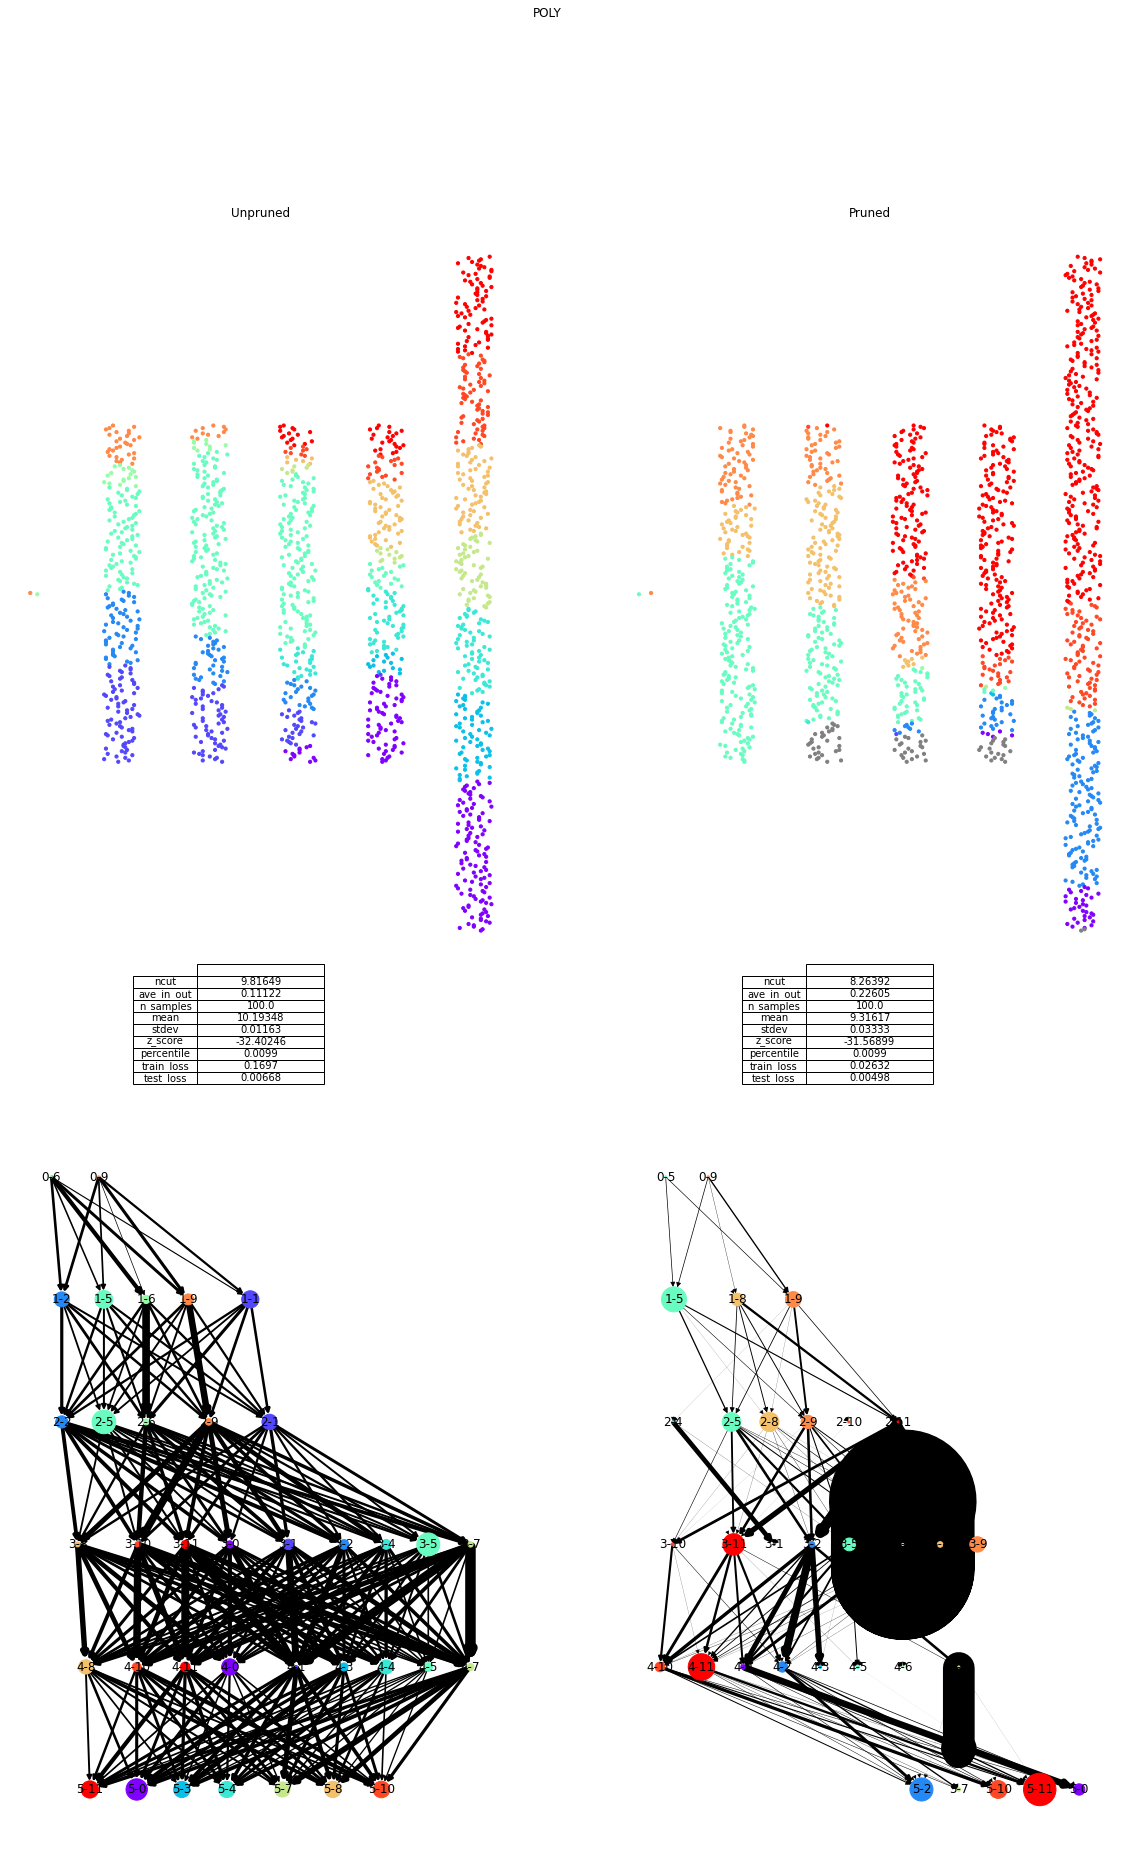

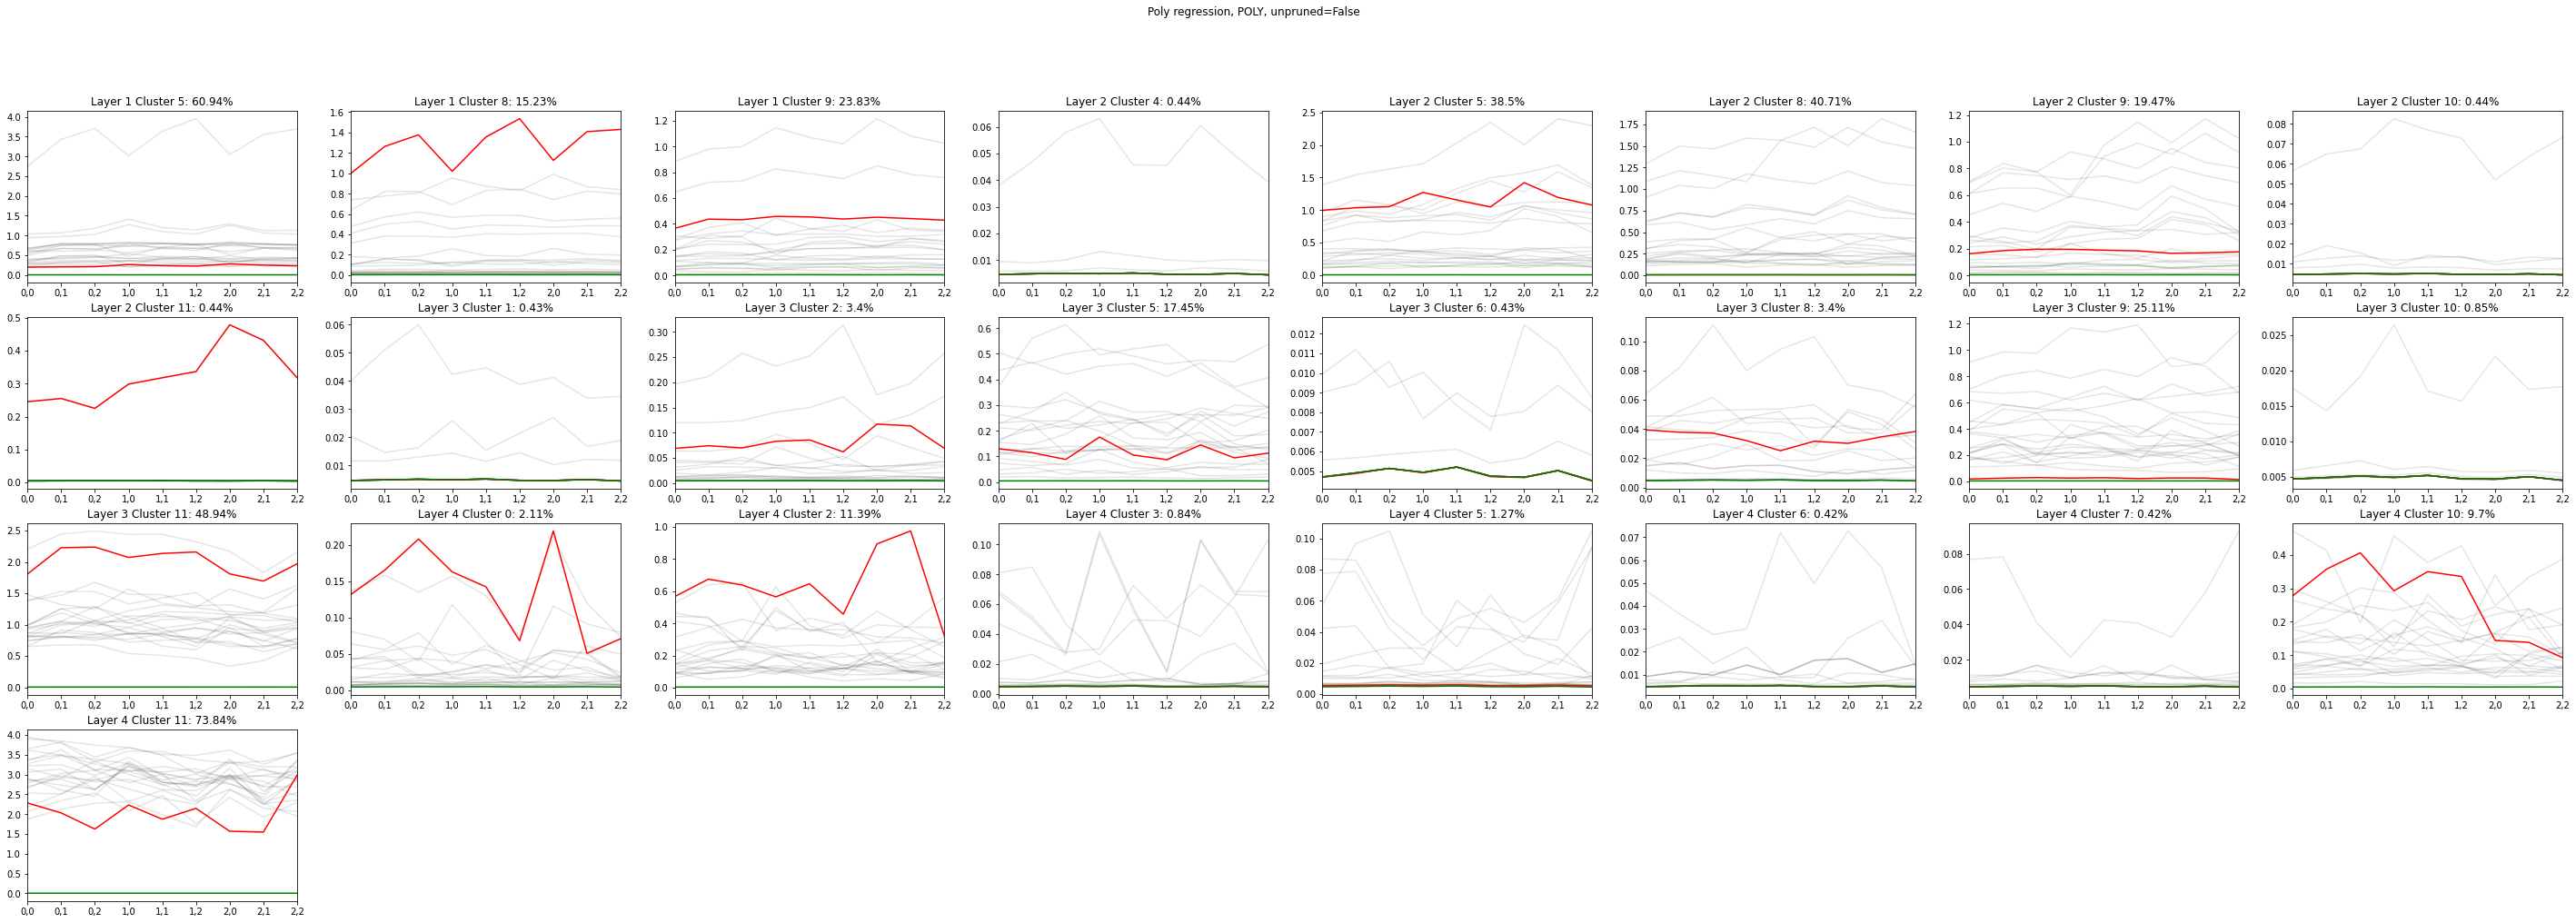

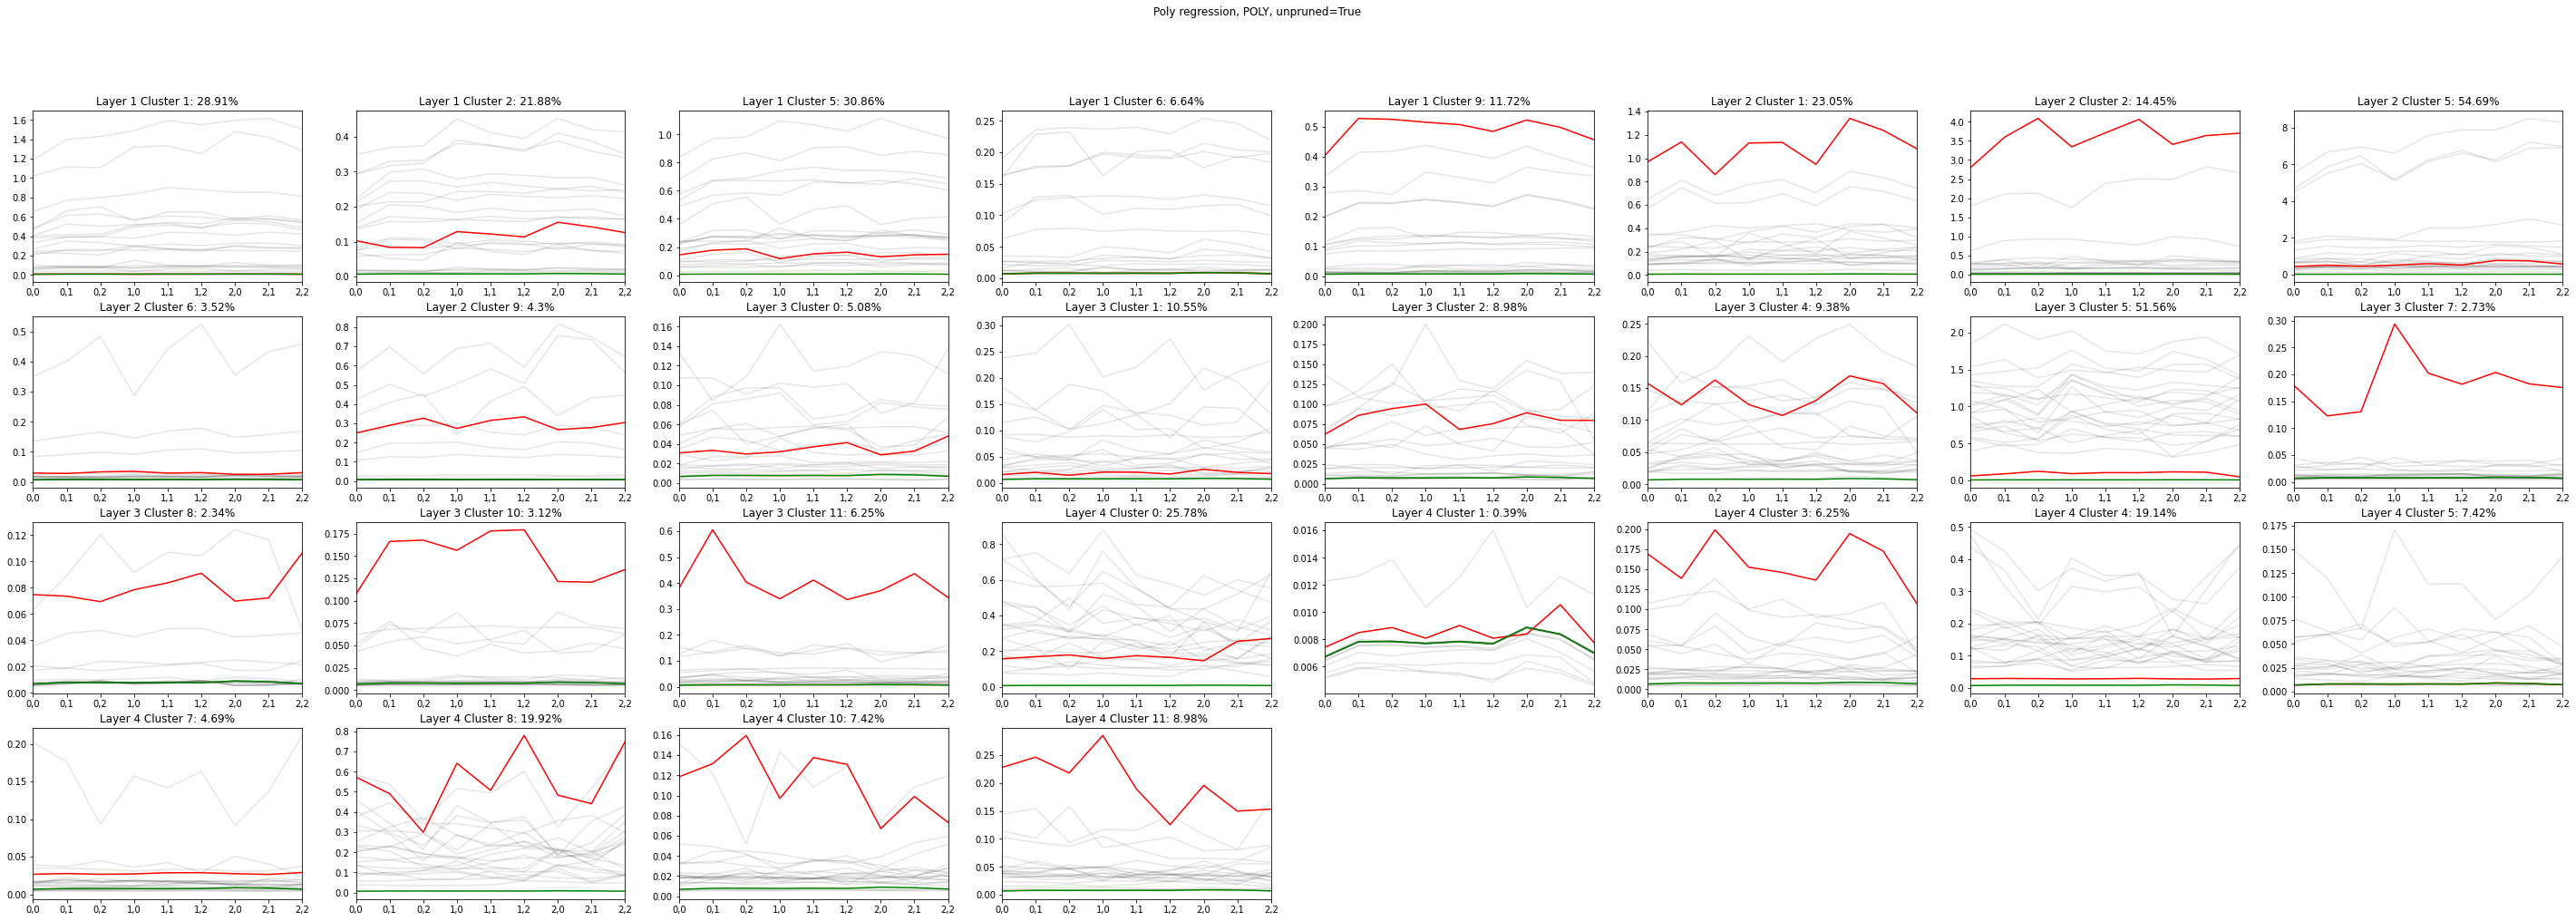

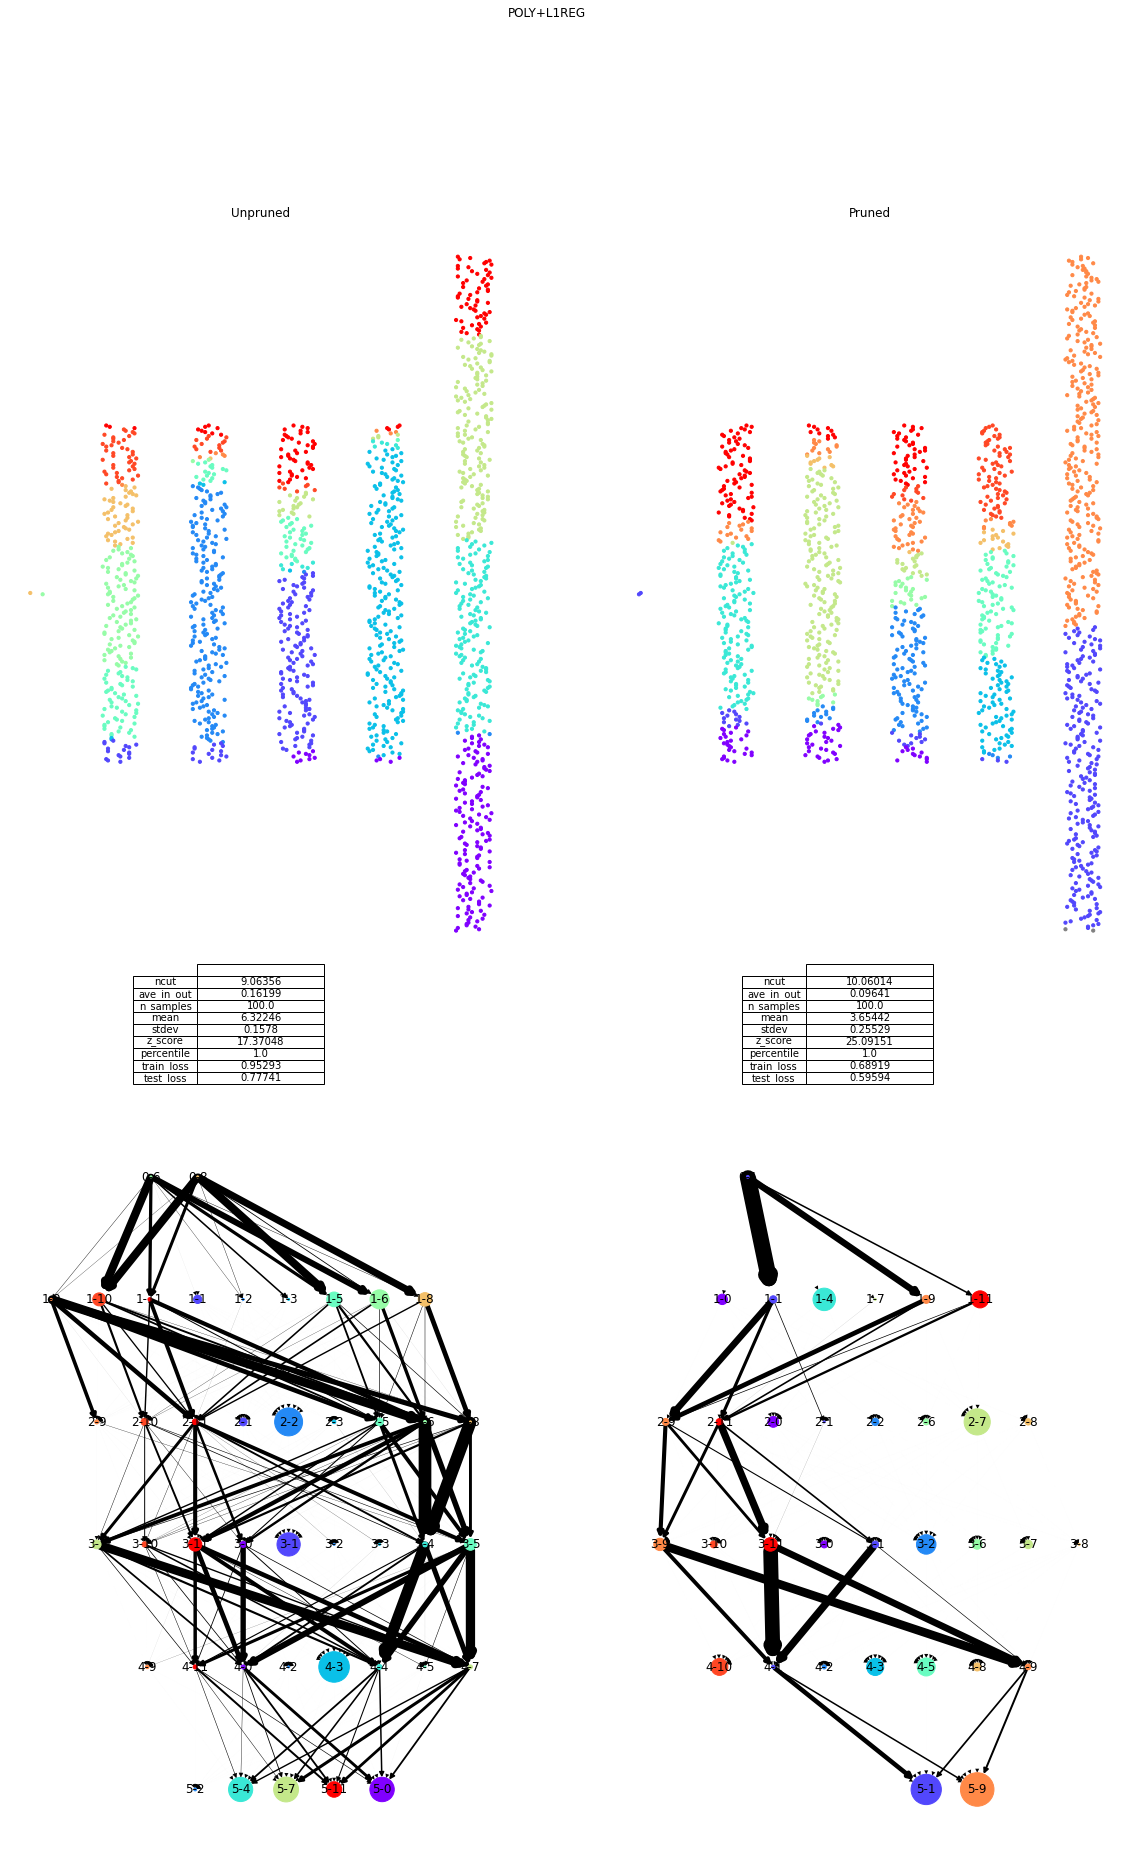

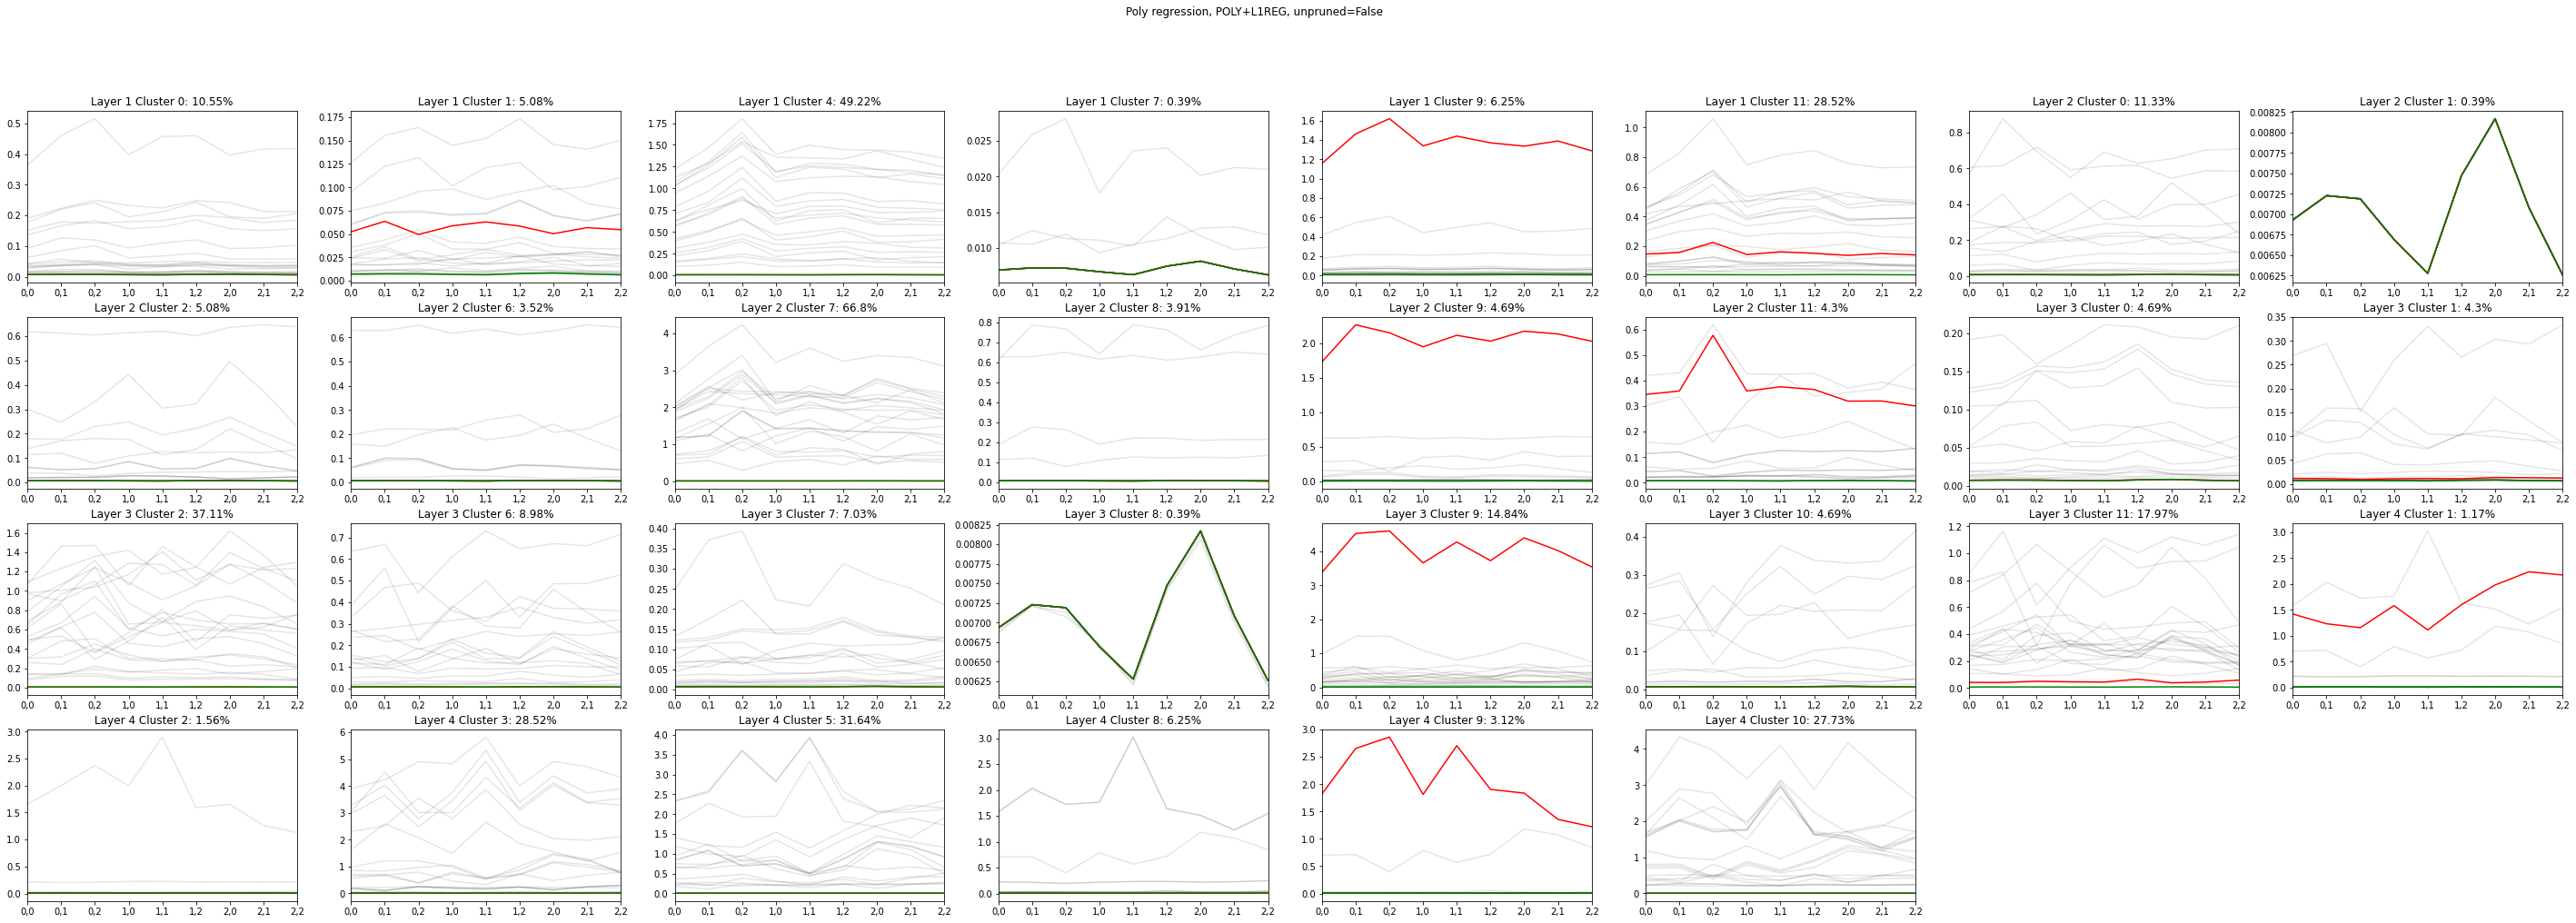

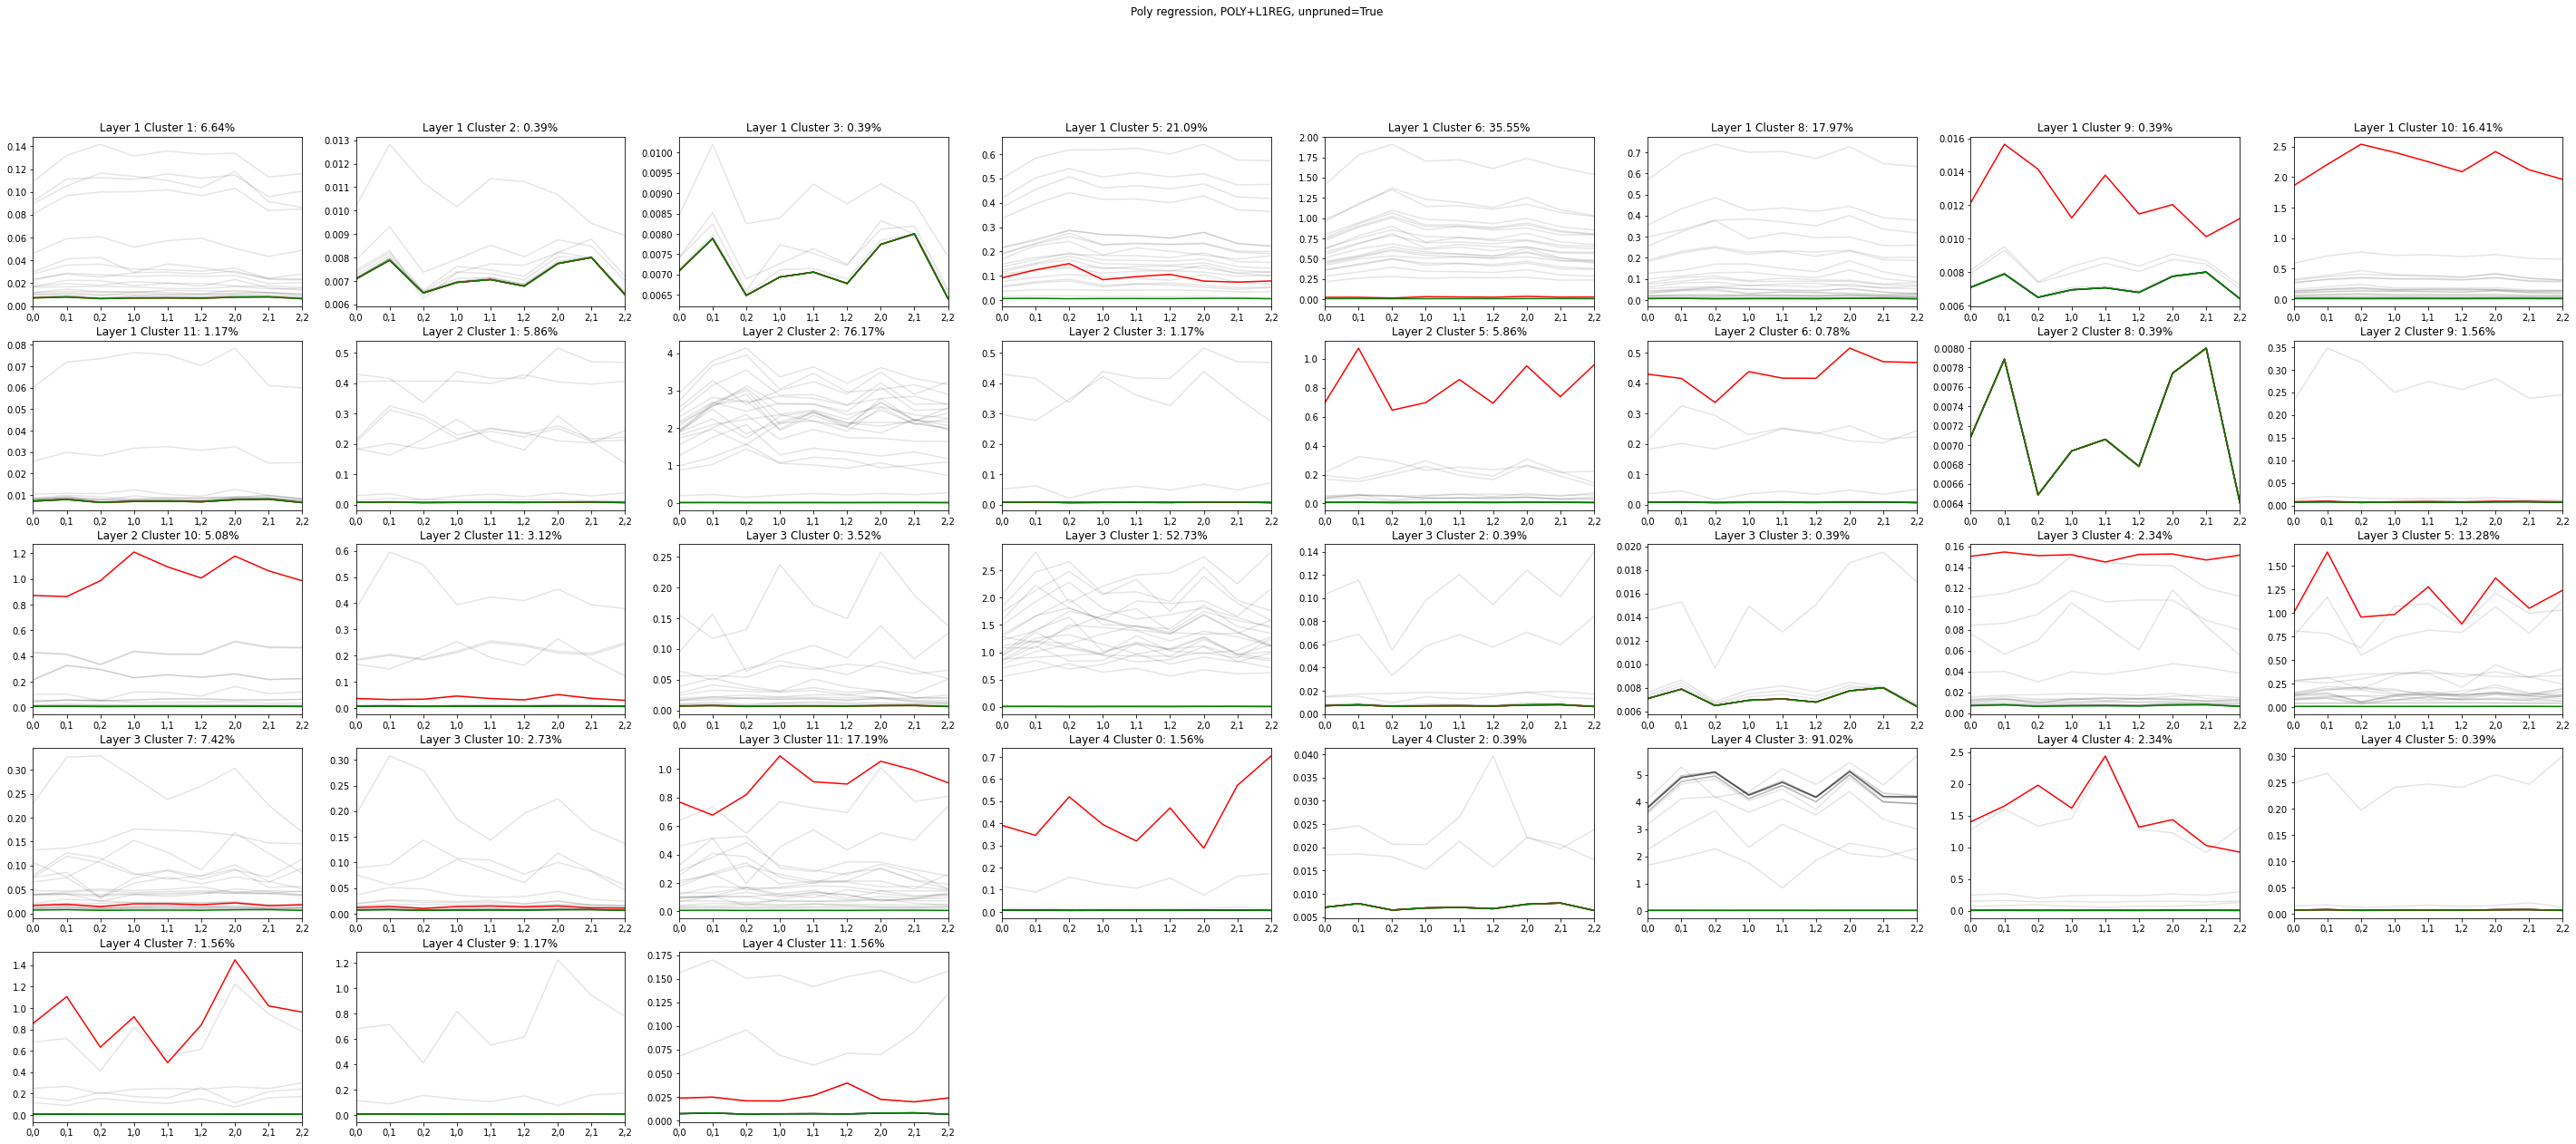

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    for tag, path in zip(model_tags, model_paths):

        clustering_results = run_double_spectral_cluster(path, n_clusters=n_clust, n_samples=n_samples)

        draw_mlp_clustering_report(path, clustering_results, n_cluster=n_clust, is_first_square=False, title=tag)

        for is_unpruned in [False, True]:

            (true_results, all_random_results, metadata, evaluation) = perform_lesion_experiment('.' + DATA_PATHS['poly'],
                                                                   path, n_clusters=n_clust, n_shuffles=n_shuffles,
                                                                                                 unpruned=is_unpruned)
            # true_results is a list of dicts with keys 'mses' and 'labels_in_layers'. 'mses' is a shape (512,) np array
            # all_random_results is a list in which each element is like true_results
            # evaluation is a dict with one key 'mses' and value giving a a shape (512,) np array
            # metadata is a list of dicts with keys 'layer', 'label', 'n_layer_label', 'label_in_layer_proportion'

            plot_all_damaged_clusters(true_results, all_random_results, metadata, evaluation,
                                          title=f'Poly regression, {tag}, unpruned={is_unpruned}')

            hypo_results = do_lesion_hypo_tests(evaluation, true_results, all_random_results)
            mean_percentiles = hypo_results['mean_percentiles']
            range_percentiles = hypo_results['range_percentiles']
            chi2_p_means = hypo_results['chi2_p_means']
            chi2_p_ranges = hypo_results['chi2_p_ranges']
            combined_p_means = hypo_results['combined_p_means']
            combined_p_ranges = hypo_results['combined_p_ranges']
            print(f'is_unpruned: {is_unpruned}')
            print(f'Mean percentiles: {mean_percentiles}')
            print(f'Rtd percentiles: {range_percentiles}')
            print(f'chi2 mean p: {chi2_p_means}')
            print(f'chi2 range p: {chi2_p_means}')
            print(f'combined mean p: {combined_p_means}')
            print(f'combined range p: {combined_p_ranges}')
            print()
